In [1]:
import pandas as pd
import time
import pandas_datareader.data as web
import datetime 
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [2]:
#数据开始和结束时间
start=datetime.datetime(2010,1,1)
end=datetime.datetime(2020,1,1)


In [3]:
#实验中提取的股票
#AAPL
#GOOGL
#INTC
#MSFT
#ORCL

In [4]:
web.get_data_yahoo('AAPL',start,end).head(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-12-31,7.619643,7.520000,7.611786,7.526072,352410800.0,6.503574
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.604801
2010-01-05,7.699643,7.616071,7.664286,7.656428,601904800.0,6.616219
2010-01-06,7.686786,7.526786,7.656428,7.534643,552160000.0,6.510980
2010-01-07,7.571429,7.466072,7.562500,7.520714,477131200.0,6.498945


In [5]:
#获得股票数据
tech=['GOOGL','INTC','MSFT','ORCL']
df=pd.DataFrame({'AAPL':web.get_data_yahoo('AAPL',start,end)['Adj Close']})
for i in tech:
    tmp=web.get_data_yahoo(i,start,end)['Adj Close']
    tmp=tmp.rename(i)
    df=pd.merge(df,tmp,how='left',left_index=True,right_index=True)

In [6]:
df.head()
#df.to_csv('D:/DataMining/基于深度学习的金融时序预测/stocks.csv')

,AAPL,GOOGL,INTC,MSFT,ORCL
Date,,,,,
2009-12-31,6.503574,310.300293,14.717187,23.801456,21.325991
2010-01-04,6.604801,313.688690,15.063472,24.168472,21.604193
2010-01-05,6.616219,312.307312,15.056260,24.176279,21.578108
2010-01-06,6.510980,304.434448,15.005755,24.027906,21.265123
2010-01-07,6.498945,297.347351,14.861475,23.778025,21.195576


In [7]:
#数据预处理
#df_pro=(df-df.mean())/df.std()
df_pro=(df.pct_change()).fillna(0)
#df_pro=(df-df.min())/(df.max()-df.min())

In [8]:
df_pro.head()

,AAPL,GOOGL,INTC,MSFT,ORCL
Date,,,,,
2009-12-31,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.015565,0.010920,0.023529,0.015420,0.013045
2010-01-05,0.001729,-0.004404,-0.000479,0.000323,-0.001207
2010-01-06,-0.015906,-0.025209,-0.003354,-0.006137,-0.014505
2010-01-07,-0.001848,-0.023280,-0.009615,-0.010400,-0.003271


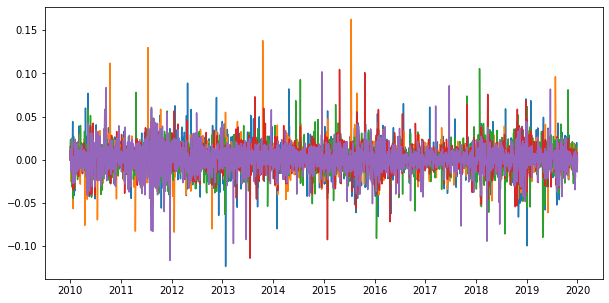

In [9]:
#数据预览
plt.figure(figsize=(10,5))
for i in df_pro.columns:
    plt.plot(df_pro[i])
plt.show()

In [10]:
#参数
time_size=20
input_size=5
cnn_channels=20
cnn_kernel_len=2

In [11]:
#不重叠地切分 -- 250 *20 的数据量
#last=df_pro.shape[0]//time_size*time_size
#input_data=np.split(df_pro.values[:last],last/time_size,axis=0)
df_pro.shape[0] // time_size*time_size

2500

In [12]:
#重叠切分
input_data=[]
output_data=[]
seq=df_pro.values
for i in range(len(seq)-time_size-1):
    input_data.append(seq[i:i+time_size])
    output_data.append(seq[i+time_size+1])
input_data=np.array(input_data)
output_data=np.array(output_data)

In [13]:
print(input_data.shape)
print(output_data.shape)

(2496, 20, 5)
(2496, 5)


In [14]:
#实验模型
class ARNNCell(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim):
        super(ARNNCell, self).__init__()
        self.input_dim=input_dim
        self.output_dim=output_dim
        self.w1=keras.layers.Dense(input_dim, activation='tanh')
        self.w2=keras.layers.Dense(input_dim, activation='tanh')
        self.w3=keras.layers.Dense(input_dim, activation='tanh')
        self.w4=keras.layers.Dense(output_dim, activation='linear')        
        self.state_size=(self.input_dim,self.input_dim)

    def call(self, inputs, states):
        pre_h=states[0]
        pre_h1=states[1]
        h=self.w2(inputs)+self.w3(pre_h)
        y=self.w1(inputs)*h
        h1=y+pre_h1
        return self.w4(h1), [h,h1]

def model_build_CNNATT():
    model=keras.Sequential([
        keras.layers.Reshape((time_size, input_size, 1), input_shape=(time_size, input_size)),
        keras.layers.Conv2D(cnn_channels, (cnn_kernel_len, input_size), activation='relu'),
        keras.layers.Reshape((time_size-cnn_kernel_len+1, cnn_channels)),
        keras.layers.RNN(ARNNCell(input_dim=40,output_dim=5))
    ])
    return model

In [15]:
#单层LSTM模型
def model_build_LSTM():
    model=keras.Sequential()
    model.add(keras.layers.LSTM(units=20,return_sequences=False))
    model.add(keras.layers.Activation('linear'))
    model.add(keras.layers.Dense(units=5))
    return model

In [16]:
##损失函数
def loss_(y_pred,y_true):
    return tf.reduce_mean(tf.square(y_pred-y_true))+tf.exp(-1*y_pred*y_true)
    #return tf.reduce_mean(tf.square(y_pred-y_true))+100*tf.exp(-(y_pred*y_true)/tf.abs(y_pred*y_true))
    #return tf.reduce_mean(tf.square(y_pred-y_true))+tf.exp(-10000*(y_pred*y_true))

In [17]:
#data to [train,test]
#数据切分成训练数据和测试数据
train_size=int(input_data.shape[0]*0.8)
train_x=input_data[:train_size]
test_x=input_data[train_size+1:]
train_y=output_data[:train_size]
test_y=output_data[train_size+1:]

In [18]:
#模型训练函数
def train_model(train_x,train_y,test_x,test_y):
    model=model_build_CNNATT()
    #model=model_build_LSTM()
    model_name='att'

    #model.compile(loss='mse',optimizer='adam')
    model.compile(loss='mse',optimizer='adam')
    history=model.fit(train_x,train_y,batch_size=4,epochs=200,verbose=1,shuffle=False)
    model.summary()
    
    loss = history.history['loss']
    predict=model.predict(test_x)
    return predict,loss,model_name

In [19]:
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(1996, 20, 5) (499, 20, 5) (1996, 5) (499, 5)


In [20]:
#训练模型
time_start = time.time()
predict,loss,model=train_model(train_x, train_y, test_x, test_y)
time_end = time.time()
print("The time used for training: " + str(time_end - time_start) + 's')

Train on 1996 samples
Epoch 1/200
1996/1996 [==============================] - 4s 2ms/sample - loss: 2.2340e-04
Epoch 2/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2383e-04
Epoch 3/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2295e-04
Epoch 4/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2330e-04
Epoch 5/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2287e-04
Epoch 6/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2343e-04
Epoch 7/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2275e-04
Epoch 8/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2302e-04
Epoch 9/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2278e-04
Epoch 10/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2283e-04
Epoch 11/200
1996/1996 [==============================] - 2s 1ms/sample - los

1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2116e-04
Epoch 91/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2104e-04
Epoch 92/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2137e-04
Epoch 93/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2195e-04
Epoch 94/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2090e-04
Epoch 95/200
1996/1996 [==============================] - 3s 1ms/sample - loss: 2.2129e-04
Epoch 96/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2085e-04
Epoch 97/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2092e-04
Epoch 98/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2080e-04
Epoch 99/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2126e-04
Epoch 100/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.2122e-04
Epoch 101/2

1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1395e-04
Epoch 180/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1235e-04
Epoch 181/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1290e-04
Epoch 182/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1391e-04
Epoch 183/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1043e-04
Epoch 184/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1072e-04
Epoch 185/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1226e-04
Epoch 186/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1271e-04
Epoch 187/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1023e-04
Epoch 188/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.1071e-04
Epoch 189/200
1996/1996 [==============================] - 2s 1ms/sample - loss: 2.0841e-04
Ep

In [21]:
predict.shape

(499, 5)

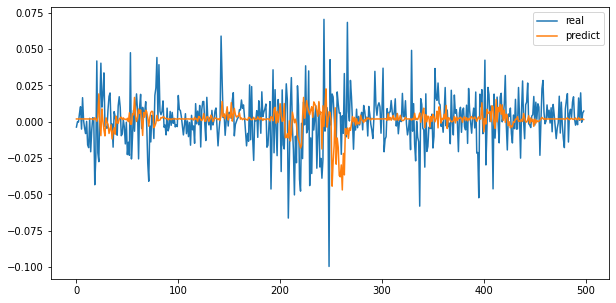

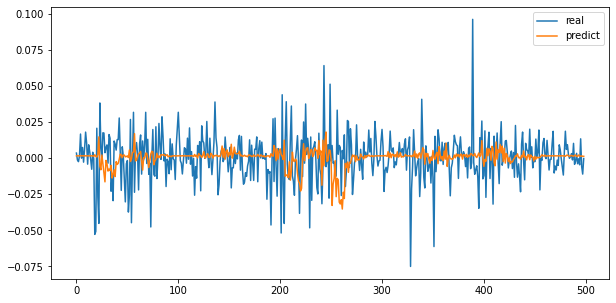

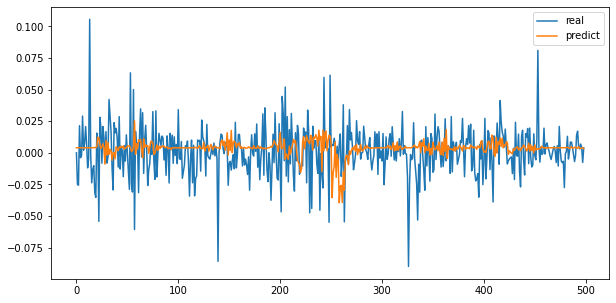

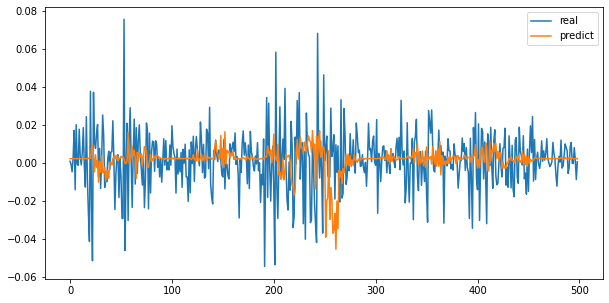

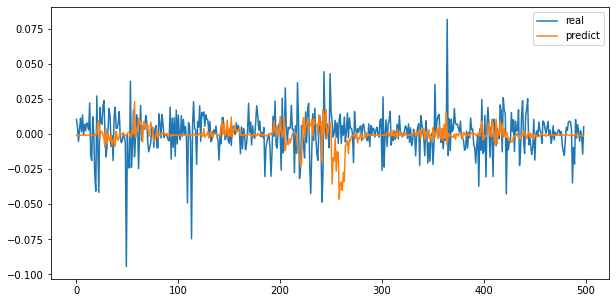

In [22]:
#真实和预测结果
test_y_list=np.split(test_y,5,axis=1)
predict_list=np.split(predict,5,axis=1)
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.plot(test_y_list[i],label='real')
    plt.plot(predict_list[i],label='predict')
    plt.legend()
    plt.show()

In [23]:
'''
test_y_list=np.split(test_y,5,axis=1)
predict_list=np.split(predict,5,axis=1)
for i in range(5):
    plt.figure(figsize=(10,5))
    plt.plot(test_y_list[i],label='real')
    plt.plot(predict_list[i],label='predict')
    plt.legend()
    plt.show()
'''


"\ntest_y_list=np.split(test_y,5,axis=1)\npredict_list=np.split(predict,5,axis=1)\nfor i in range(5):\n    plt.figure(figsize=(10,5))\n    plt.plot(test_y_list[i],label='real')\n    plt.plot(predict_list[i],label='predict')\n    plt.legend()\n    plt.show()\n"

In [24]:
print('rmse:{}'.format(np.sqrt(np.mean(np.square(predict-test_y)))))

rmse:0.018176668176858674


In [25]:
#选取增量最大的股票进行投递  数据为价格
def stragety():
    #init
    cap_str=100000
    cap_cg=[cap_str]
    for i in range(len(predict)-1):
        cur,ind=0,-1
        for j in range(input_size):
            if(predict[i+1][j]/predict[i][j]-1>cur):
                cur=predict[i+1][j]/predict[i][j]-1
                ind=j
        if cur>0:
            cap_str=cap_str*test_y[i+1][ind]/test_y[i][ind]
        cap_cg.append(cap_str)
    return cap_cg

def origin():
    cap_ori=100000
    cap_cg=[cap_ori]
    for i in range(len(predict)-1):
        cap_ori=cap_ori*test_y[i+1][0]/test_y[i][0]
        cap_cg.append(cap_ori)
    return cap_cg

In [26]:
#选取增量最大的股票进行投递  数据为增长率
def stragety_rate():
    #init
    cap_str=100000
    cap_cg=[cap_str]
    for i in range(len(predict)-1):
        cur,ind=0,-1
        for j in range(input_size):
            if(predict[i+1][j]>cur):
                cur=predict[i+1][j]
                ind=j
        if cur>0:
            cap_str=cap_str*(1+test_y[i+1][ind])
        cap_cg.append(cap_str)
    return cap_cg

def origin_rate():
    cap_ori=100000
    cap_cg=[cap_ori]
    for i in range(len(predict)-1):
        cap_ori=cap_ori*(1+test_y[i+1][0])
        cap_cg.append(cap_ori)
    return cap_cg

In [27]:
'''
#策略结果  数据为价格
cap_s=stragety()
cap_o=origin()
plt.plot(cap_s)
plt.plot(cap_o)
plt.show()
'''

'\n#策略结果  数据为价格\ncap_s=stragety()\ncap_o=origin()\nplt.plot(cap_s)\nplt.plot(cap_o)\nplt.show()\n'

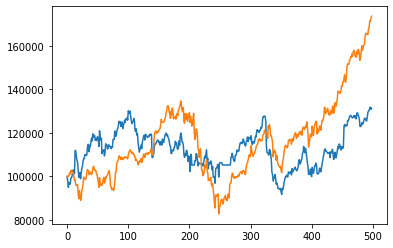

In [28]:
#策略结果 数据为增长率
cap_s=stragety_rate()
cap_o=origin_rate()
plt.plot(cap_s)
plt.plot(cap_o)
plt.show()

In [29]:
def log():

SyntaxError: unexpected EOF while parsing (<ipython-input-29-6153ca42db5c>, line 1)